# Short_range National Water Model Forecast
### Workflow for creating an 18 hour stream flow forecast given a date, time, and NHDplus COMID (stream segment identifier)

In [58]:
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from scipy.interpolate import interp1d

%matplotlib inline

## Set up the Google Cloud File System

In [2]:
fs = gcsfs.GCSFileSystem(project='national-water-model')

## Open all netcdf files of interest, concat them into an xarray multifile dataset

- This step takes longer than expected due to reading from GCS over the internet

In [3]:
date = '20190802' # a date
start_time = '00' # start at 00:00 because its easy at the moment
comid = 4512772 # some small segment on the Potomac near DC
# comid = 229757 # the South Platte River in Denver
# comid = 7471678 # somewhere on the Mississippi River

In [4]:
open_ncdfs = []
for i in range(1,19): # for times 1-18
    hr_from_start = str(i).zfill(3)
    filepath = f'national-water-model/nwm.{date}/short_range/nwm.t{start_time}z.short_range.channel_rt.f{hr_from_start}.conus.nc'
    file = fs.open(filepath, 'rb')
    open_ncdfs.append(file)
mfdset = xr.open_mfdataset(open_ncdfs)

## Get the model analysis_assim time and streamflow (AKA time zero)

In [45]:
filepath = f'national-water-model/nwm.{date}/analysis_assim/nwm.t{start_time}z.analysis_assim.channel_rt.tm00.conus.nc'
file = fs.open(filepath, 'rb')
assim = xr.open_dataset(file)
ds = assim.sel(feature_id=comid)
assim_time = ds['time'].values[0]
df = assim['streamflow'].to_dataframe()
assim_flow = df.loc[comid].values[0]
print(assim_time, assim_flow)

2019-08-02T00:00:00.000000000 112.6999974809587


## Get only the streamflow data for the COMID of interest

In [46]:
output_da = mfdset.sel(feature_id=comid)['streamflow']
times = output_da['time'].values
arr = output_da.values
d = {**{assim_time: assim_flow}, **dict(zip(times, arr))}
df = pd.DataFrame([d]).T.rename(columns={0:'streamflow'})
df.head()

,streamflow
2019-08-02 00:00:00,112.699997
2019-08-02 01:00:00,119.389997
2019-08-02 02:00:00,124.859997
2019-08-02 03:00:00,129.759997
2019-08-02 04:00:00,133.689997


# Plot it 

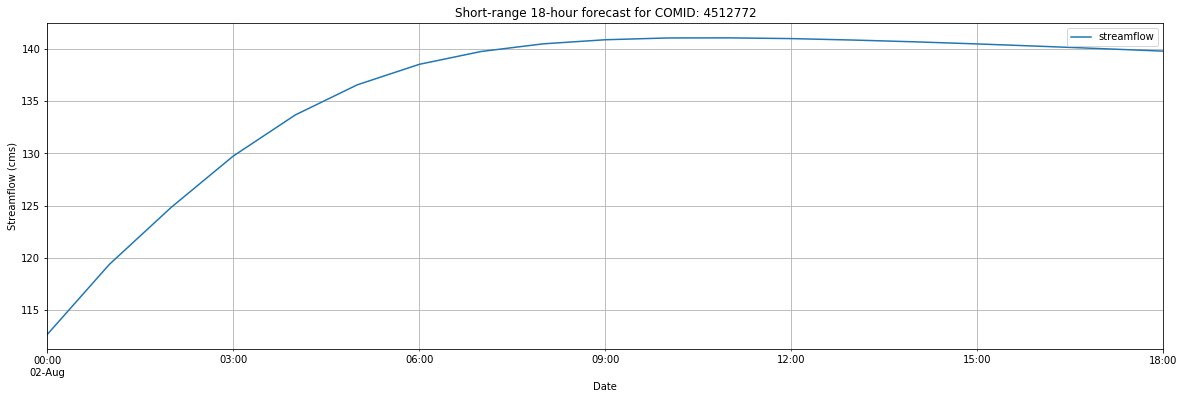

In [53]:
ax = df.plot(figsize=(20,6), title=f'Short-range 18-hour forecast for COMID: {comid}')
ax.grid(True, which="both")
# ax.set_xticklabels(pd.Series(df.index).dt.strftime('%Y-%m-%d %H:00'), rotation='vertical')
ax.set(xlabel='Date', ylabel='Streamflow (cms)');

# Convert Flow to Stage

In [54]:
ds = xr.open_dataset(r'data/hydroprop-fulltable2D.nc')
dis_ds = ds.Discharge.sel(CatchId=comid)
dis_df = dis_ds.to_dataframe().reset_index().drop(columns=['CatchId']).dropna()

In [55]:
dis_df.head()

,Stage,Discharge
0,0.0000,0.000000
1,0.3048,30.085741
2,0.6096,96.720480
3,0.9144,180.899337
4,1.2192,323.340296


## Make an interpolation function to convert from streamflow to stage based on the rating curve provided by the NWM

In [63]:
f = interp1d(dis_df.Discharge, dis_df.Stage, kind='cubic')
stage_df = df.apply(f).rename(columns={'streamflow': 'stage'})

## Plot the forecasted stage depth

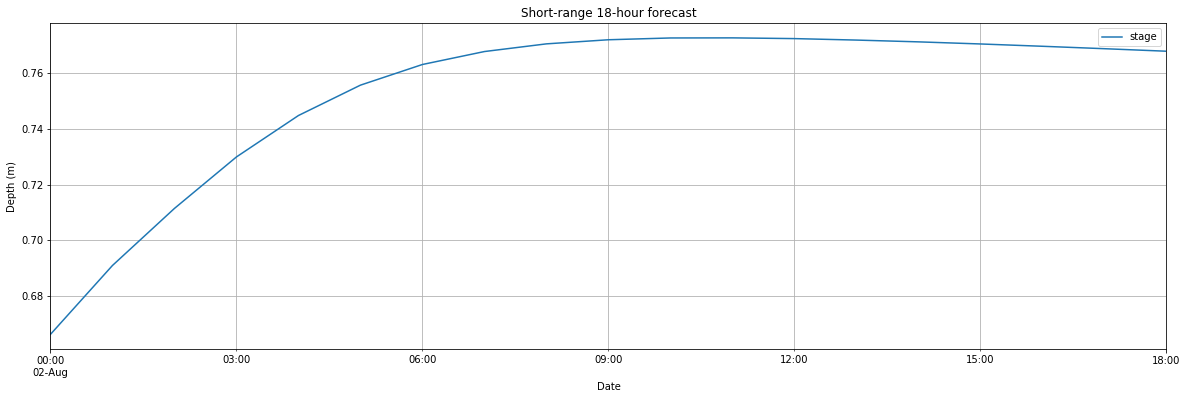

In [64]:
ax = stage_df.plot(figsize=(20,6), title='Short-range 18-hour forecast')
ax.grid(True, which="both")
ax.set(xlabel='Date', ylabel='Depth (m)');